# Install and import packages



We’ll use two main tools:
- CELLxGENE Census to fetch public data (so we don't have to download giant files onto our computer)
- Scanpy to analyze data (https://scanpy.readthedocs.io/en/stable/tutorials/basics/clustering.html)

In [ ]:
!pip install -q scanpy cellxgene-census anndata matplotlib igraph


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 kB 7.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take

In [ ]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cellxgene_census

# Explore the census

# Download dataset of interest
- CD8 T cells at: https://cellxgene.cziscience.com/collections/77f9d7e9-5675-49c3-abed-ce02f39eef1b


In [ ]:
with cellxgene_census.open_soma() as census:

    # Reads SOMADataFrame as a slice
    cell_metadata = census["census_data"]["homo_sapiens"].obs.read(
        value_filter = "dataset_id == 'b90d4a42-714c-4590-b548-6e75e6c081e8'",
        column_names = ["assay", "cell_type", "tissue", "tissue_general",
                        "suspension_type", "disease", "dataset_id", "sex",
                        "donor_id", "soma_joinid"]
    )

    # Concatenates results to pyarrow.Table
    cell_metadata = cell_metadata.concat()

    # Converts to pandas.DataFrame
    cell_metadata = cell_metadata.to_pandas()

    print(cell_metadata)

The "stable" release is currently 2025-11-08. Specify 'census_version="2025-11-08"' in future calls to open_soma() to ensure data consistency.
INFO:cellxgene_census:The "stable" release is currently 2025-11-08. Specify 'census_version="2025-11-08"' in future calls to open_soma() to ensure data consistency.


            assay                                          cell_type tissue  \
0       10x 3' v3                           mucosal invariant T cell  blood   
1       10x 3' v3  naive thymus-derived CD8-positive, alpha-beta ...  blood   
2       10x 3' v3  naive thymus-derived CD8-positive, alpha-beta ...  blood   
3       10x 3' v3  naive thymus-derived CD8-positive, alpha-beta ...  blood   
4       10x 3' v3                           mucosal invariant T cell  blood   
...           ...                                                ...    ...   
406725  10x 3' v3  naive thymus-derived CD8-positive, alpha-beta ...  blood   
406726  10x 3' v3                                 CD8aa(I) thymocyte  blood   
406727  10x 3' v3                          mature gamma-delta T cell  blood   
406728  10x 3' v3  naive thymus-derived CD8-positive, alpha-beta ...  blood   
406729  10x 3' v3  naive thymus-derived CD8-positive, alpha-beta ...  blood   

       tissue_general suspension_type disease  \
0 

In [ ]:
# get some stats about the data

print("Total cells:", len(cell_metadata))
print("Cell types:", len(cell_metadata["cell_type"].unique()))

print("Sex counts:")
print(cell_metadata["sex"].value_counts())

print("Donor ids:", len(cell_metadata["donor_id"].unique()))

In [ ]:
# randomly downsample to 50k cells for memory purposes
n_cells = 50000
sampled_obs = cell_metadata.sample(n_cells, random_state=42)
sampled_cell_ids = sampled_obs["soma_joinid"].tolist()

# look at sex distribution in downsampled as an example
print(sampled_obs["sex"].value_counts())


In [ ]:
# Get object (will take a few minutes)
with cellxgene_census.open_soma() as census:
  adata = cellxgene_census.get_anndata(
      census,
      organism="Homo sapiens",
      obs_coords=sampled_cell_ids,    # 50k subsampled cells
      obs_column_names=[
          "soma_joinid",
          "dataset_id",
          "assay",
          "cell_type",
          "sex",
          "donor_id",
          "disease",
          "tissue",
          "tissue_general",
      ],
      var_column_names=["soma_joinid", "feature_id", "feature_name", "feature_length"],
  )

# Make gene names the var index
adata.var_names = adata.var["feature_name"]
adata.obs_names = adata.obs["soma_joinid"].astype(str)

adata


The "stable" release is currently 2025-11-08. Specify 'census_version="2025-11-08"' in future calls to open_soma() to ensure data consistency.
INFO:cellxgene_census:The "stable" release is currently 2025-11-08. Specify 'census_version="2025-11-08"' in future calls to open_soma() to ensure data consistency.
/usr/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


AnnData object with n_obs × n_vars = 50000 × 61497
    obs: 'soma_joinid', 'dataset_id', 'assay', 'cell_type', 'sex', 'donor_id', 'disease', 'tissue', 'tissue_general'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

## Preprocessing  
- Quality Control
- Normalization
- Identify highly variable features
- Dimensional Reduction

In [ ]:
adata.var
len(adata.var["feature_name"].unique())
# have some duplicate gene names so have to do this
adata.var_names_make_unique()

/tmp/ipython-input-3246169212.py:4: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`. Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  adata.var_names_make_unique()


## Preprocessing: Quality Control

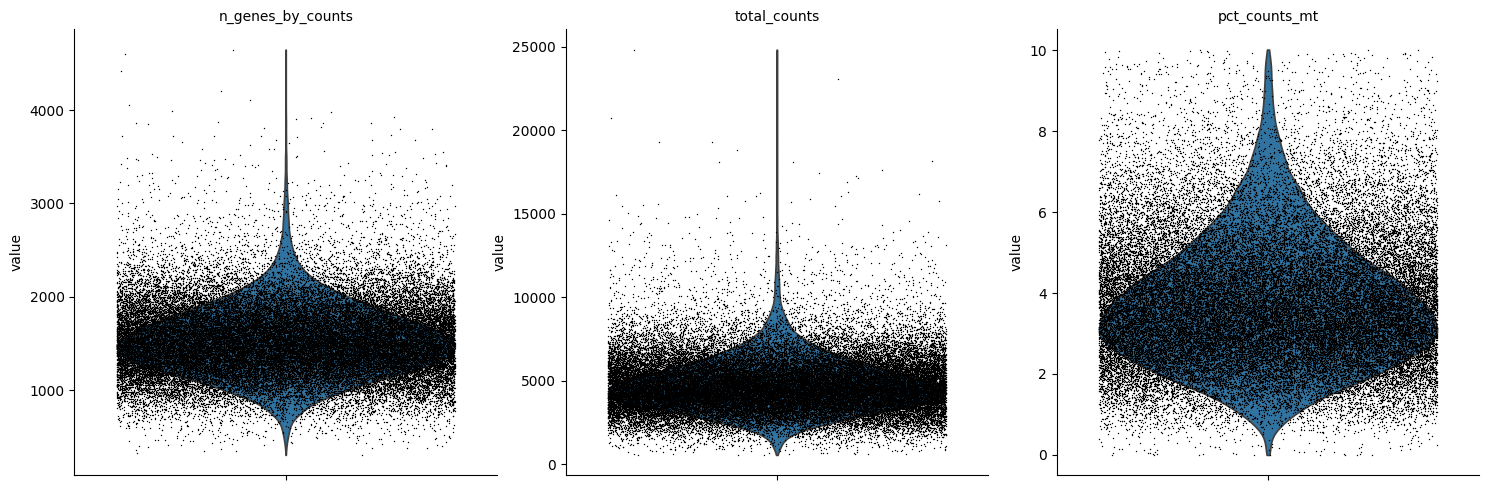

In [ ]:
# mitochondrial genes, "MT-" for human
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=True)
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)


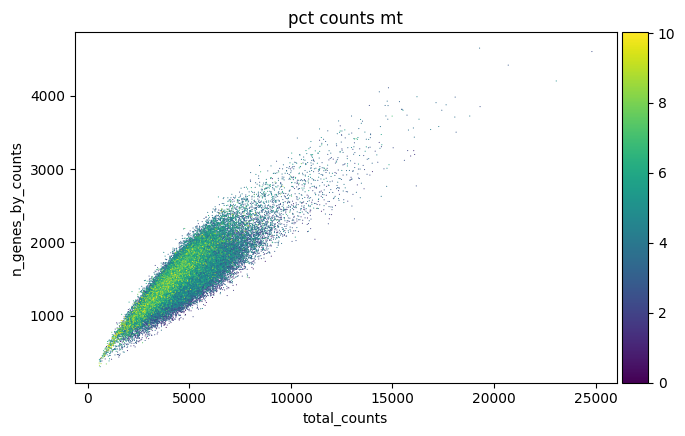

In [ ]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")


In [ ]:
# Filter out low quality cells and genes
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [ ]:
adata
# cells were already filtered, filtering genes removes genes not expressed in the data we downsampled

AnnData object with n_obs × n_vars = 50000 × 20659
    obs: 'soma_joinid', 'dataset_id', 'assay', 'cell_type', 'sex', 'donor_id', 'disease', 'tissue', 'tissue_general', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [ ]:
# Optionally, identify doublets:
# sc.pp.scrublet(adata, batch_key="sample")

## Preprocessing: Normalization

In [ ]:
# Save counts as backup
adata.layers["counts"] = adata.X.copy()
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

## Preprocessing: Feature Selection

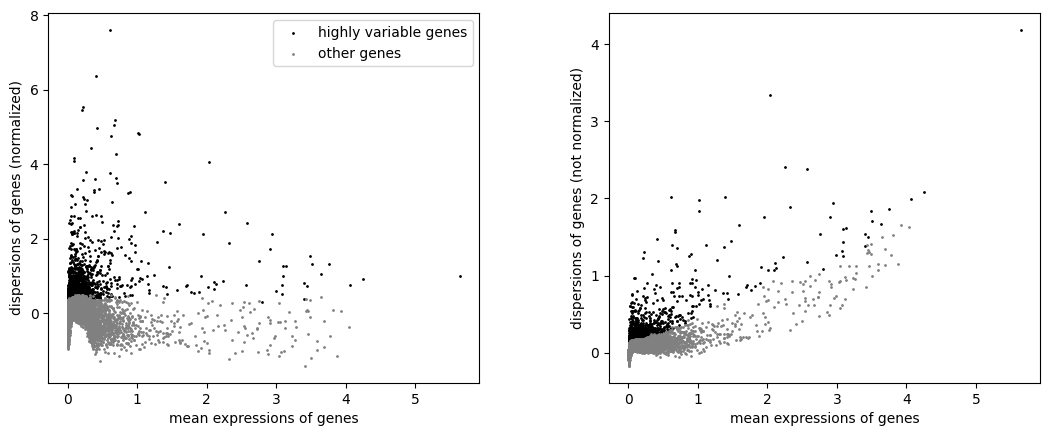

HVGs: 2000


In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="donor_id")
sc.pl.highly_variable_genes(adata)


## Preprocessing: Dimensionality Reduction with PCA

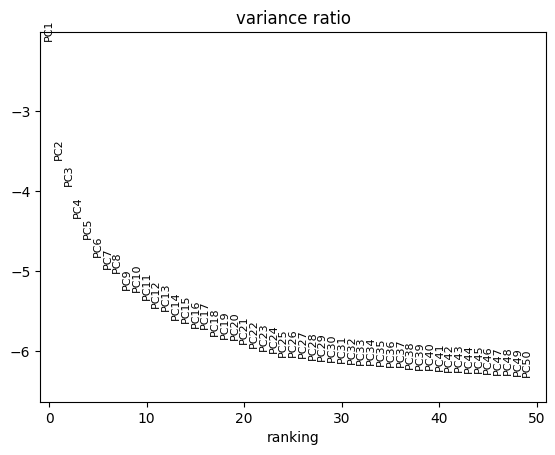

In [ ]:
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

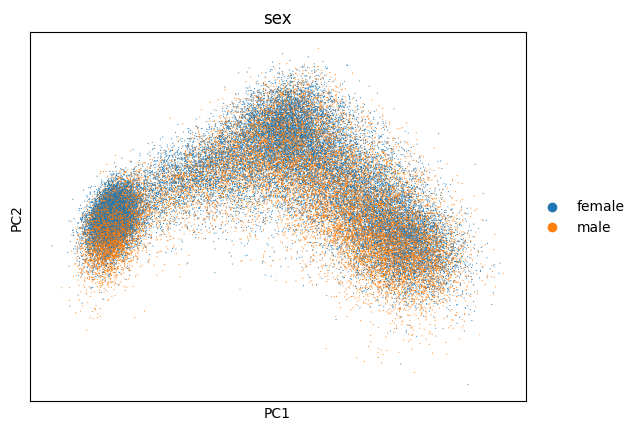

In [ ]:
# color PCA by celltype and sex and donor id
sc.pl.pca(adata, color=["sex"])

In [ ]:
# build neighbor graph and run umap
sc.pp.neighbors(adata)
sc.tl.umap(adata)
# we see the most prominent sex diffs in cd4 and cd8 t cells

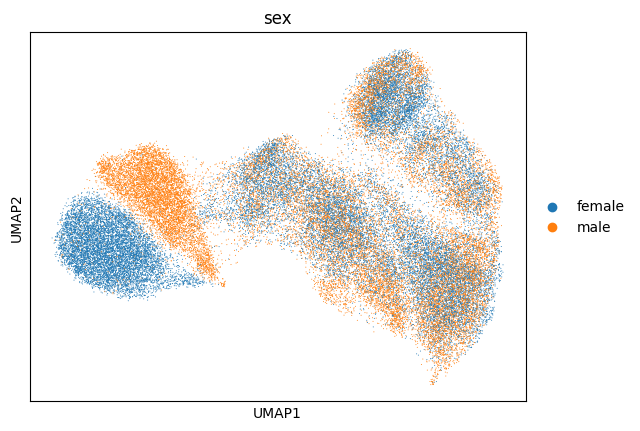

In [ ]:
sc.pl.umap(
    adata,
    color="sex",
    size=2
)

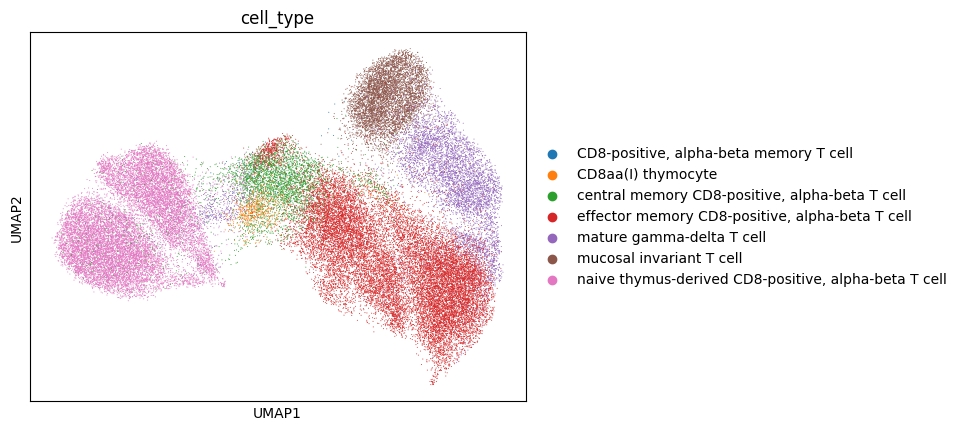

In [ ]:
sc.pl.umap(
    adata,
    color="cell_type",
    size=2
)

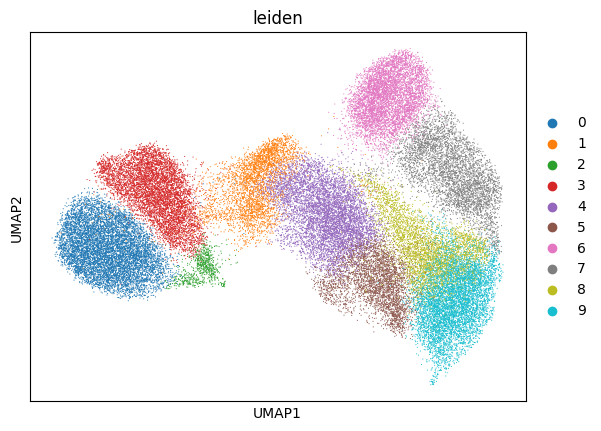

In [ ]:
# clustering

sc.tl.leiden(adata, flavor="igraph", n_iterations=2,)
sc.pl.umap(adata, color=["leiden"])


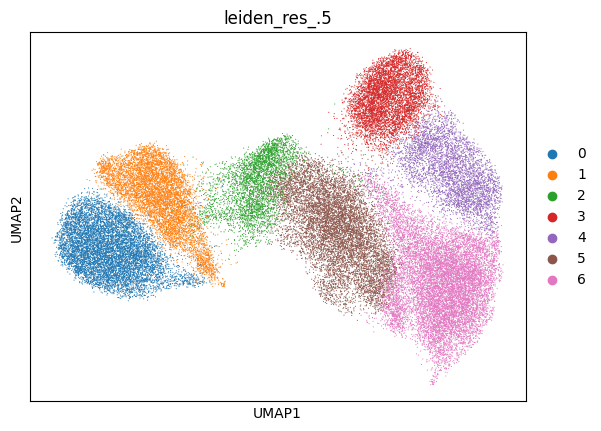

In [ ]:
# clustering with a different resolution
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 0.5, key_added= "leiden_res_.5")
sc.pl.umap(adata, color=["leiden_res_.5"])

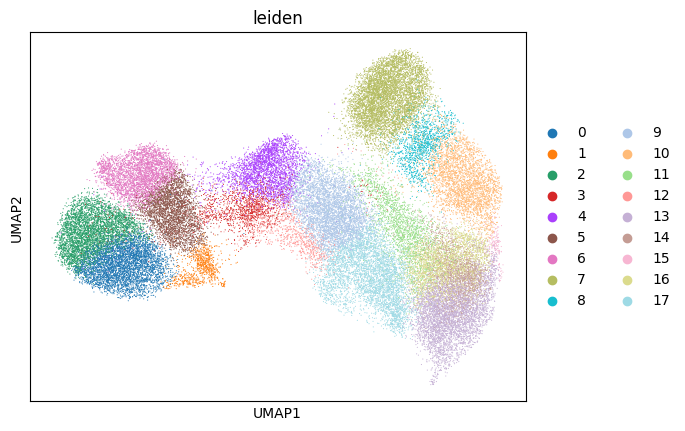

In [ ]:
# clustering with a different resolution
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution = 2)
sc.pl.umap(adata, color=["leiden"])

## Analysis: Differential expression between males and females in data
- We're doing this across the different CD8 cell states, but it could also be worthwhile to do this for each cell state individually since some seem to show more sex specific effects than others on the UMAP



In [ ]:
sc.tl.rank_genes_groups(adata, groupby='sex', method='wilcoxon')


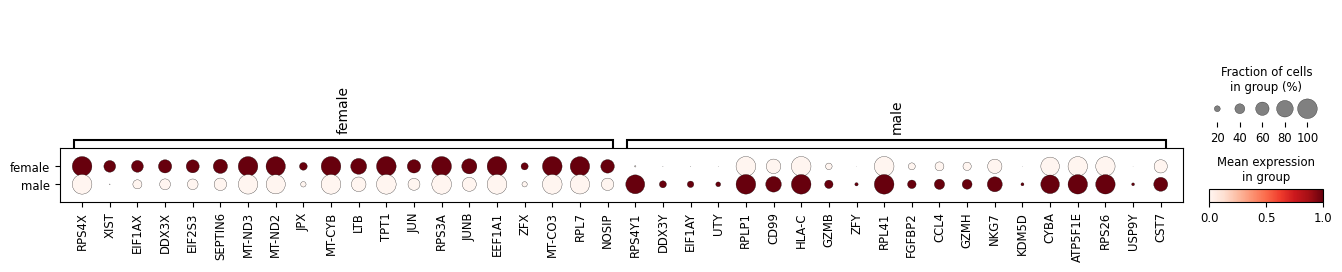

In [ ]:
sc.pl.rank_genes_groups_dotplot(
    adata,
    n_genes=20,
    standard_scale='var',
    show=True
)

In [ ]:
df_female = sc.get.rank_genes_groups_df(adata, key="rank_genes_groups", group = "female")
df_female[1:10]

,names,scores,logfoldchanges,pvals,pvals_adj
1,XIST,95.801735,6.308447,0.000000e+00,0.000000e+00
2,EIF1AX,34.218536,0.756548,1.281790e-256,4.413416e-253
3,DDX3X,33.792122,0.639928,2.574472e-250,7.598002e-247
4,EIF2S3,32.293358,0.617273,8.669736e-229,2.238851e-225
5,SEPTIN6,25.815756,0.433454,5.900923e-147,1.219072e-143
6,MT-ND3,25.490126,0.233474,2.536560e-143,4.763890e-140
7,MT-ND2,23.555639,0.237040,1.098971e-122,1.891970e-119
8,JPX,22.243185,0.842758,1.312984e-109,1.937495e-106
9,MT-CYB,22.021017,0.172594,1.811508e-107,2.494930e-104


In [ ]:
df_male = sc.get.rank_genes_groups_df(adata, key="rank_genes_groups", group = "male")
df_male[1:10]

,names,scores,logfoldchanges,pvals,pvals_adj
1,DDX3Y,48.372921,6.489479,0.000000e+00,0.000000e+00
2,EIF1AY,43.472225,6.479644,0.000000e+00,0.000000e+00
3,UTY,29.219774,6.390003,1.087653e-187,2.496647e-184
4,RPLP1,22.331171,0.133073,1.840413e-110,2.924699e-107
5,CD99,21.539141,0.339080,6.693756e-103,8.642894e-100
6,HLA-C,20.268787,0.149656,2.425611e-91,2.637405e-88
7,GZMB,20.042376,0.802554,2.352638e-89,2.430157e-86
8,ZFY,17.840878,6.691828,3.403040e-71,3.195610e-68
9,RPL41,17.075909,0.064350,2.243043e-65,1.853561e-62


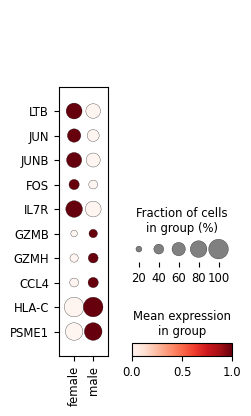

In [ ]:
genes_to_plot = ["LTB", "JUN", "JUNB", "FOS", "IL7R", "GZMB", "GZMH", "CCL4", "HLA-C", "PSME1"]

# Dotplot by sex
sc.pl.dotplot(
    adata,
    var_names=genes_to_plot,
    groupby="sex",
    standard_scale="var",
    swap_axes=True
)

This notebook represents an initial exploratory analysis and not a full biological study. As I mentioned in the talk, DE at the single-cell level (which we did here) can lead to false positives due to pseudoreplication. To be more statistically robust, DE should be done on pseudobulked samples (aggregating counts per donor / condition). More information can be found here: https://www.sc-best-practices.org/conditions/differential_gene_expression.html
